# Определяем перспективный тариф для телеком-компании «Мегалайн»

In [333]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib as mpl
import seaborn as sns

<div class="alert alert-info" role="alert">
    <p class="mb-0">В коде использую <code>display()</code>, потомучто это однозначно даёт понять что планируется вывод / печать результатов. То есть использую <code>display()</code> намеренно, хотя понимаю что можно и без него выводить данные. 👌</p>
</div>

## Шаг 0. Введение

В этом учебном проекте сделаем предварительный анализ тарифов на выборке данных 500 пользователей «Мегалайна». Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<hr>

## Шаг 1. Знакомимся с данными изучаем общую информацию

Откройте файл с данными и изучите общую информацию

In [334]:
calls_df = pd.read_csv('./datasets/calls.csv')
internet_df = pd.read_csv('./datasets/internet.csv', index_col=0)
messages_df = pd.read_csv('./datasets/messages.csv')
tariffs_df = pd.read_csv('./datasets/tariffs.csv')
users_df = pd.read_csv('./datasets/users.csv')

### Описание данных

#### Таблица calls (информация о звонках):
`id` — уникальный номер звонка
`call_date` — дата звонка
`duration` — длительность звонка в минутах
`user_id` — идентификатор пользователя, сделавшего звонок

In [335]:
display(
    calls_df.info(),
    calls_df.sample(3)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
121067,1313_31,2018-12-11,9.42,1313
108999,1281_432,2018-08-01,20.23,1281
70947,1177_127,2018-10-19,0.23,1177


#### Таблица internet (информация об интернет-сессиях):
`id` — уникальный номер сессии
`mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
`session_date` — дата интернет-сессии
`user_id` — идентификатор пользователя

In [336]:
display(
    internet_df.info(),
    internet_df.sample(3),
    # len(list(internet_df['id'].unique()))
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

,id,mb_used,session_date,user_id
12832,1045_8,502.71,2018-05-25,1045
101814,1340_525,442.14,2018-05-21,1340
38402,1134_457,0.00,2018-10-29,1134


#### Таблица messages (информация о сообщениях):
`id` — уникальный номер сообщения
`message_date` — дата сообщения
`user_id` — идентификатор пользователя, отправившего сообщение

In [337]:
display(
    messages_df.info(),
    messages_df.sample(3),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
2570,1005_432,2018-04-26,1005
6069,1026_3,2018-12-26,1026
12580,1054_136,2018-03-22,1054


#### Таблица tariffs (информация о тарифах):
`tariff_name` — название тарифа
`rub_monthly_fee` — ежемесячная абонентская плата в рублях
`minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
`messages_included` — количество сообщений в месяц, включённых в абонентскую плату
`mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
`rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
`rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
`rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [338]:
display(
    tariffs_df,
    tariffs_df['tariff_name'].unique(),
)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


array(['smart', 'ultra'], dtype=object)

#### Таблица users (информация о пользователях):
`user_id` — уникальный идентификатор пользователя
`first_name` — имя пользователя
`last_name` — фамилия пользователя
`age` — возраст пользователя (годы)
`reg_date` — дата подключения тарифа (день, месяц, год)
`churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
`city` — город проживания пользователя
`tariff` — название тарифного плана

In [339]:
display(
    users_df.info(),
    users_df.sample(3),
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
492,1492,63,NaN,Санкт-Петербург,Руслана,Артёменко,2018-06-26,smart
29,1029,51,NaN,Екатеринбург,Алексей,Селезнев,2018-09-15,smart
363,1363,69,NaN,Нижний Тагил,Оксана,Болдырева,2018-03-04,ultra


<hr>

## Шаг 2. Подготавливаем данные

calls_df

internet_df

messages_df

tariffs_df

In [340]:
users_df

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


calls_df
internet_df
messages_df
tariffs_df
users_df

### U

In [341]:
display(
    users_df.loc[users_df['churn_date'].notna()]
)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


### Дубликаты

In [342]:
display(
    calls_df.loc[calls_df.duplicated()].count()
)

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [343]:
display(
    internet_df.loc[internet_df.duplicated()].count()
)

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [344]:
display(
    messages_df.loc[messages_df.duplicated()].count()
)

id              0
message_date    0
user_id         0
dtype: int64

In [345]:
display(
    users_df.loc[users_df.duplicated()].count(),
    users_df['user_id'].value_counts().sum()
)

user_id       0
age           0
churn_date    0
city          0
first_name    0
last_name     0
reg_date      0
tariff        0
dtype: int64

500

### Найдите и исправьте ошибки в данных, если они есть.

In [346]:
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], errors='coerce', format='%Y-%m-%d')

In [347]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], errors='coerce', format='%Y-%m-%d')

In [348]:
print(
    'columns',
    list(users_df.columns),

    '\nage description',
    users_df['age'].describe(),

    '\nregistration date min → max',
    users_df['reg_date'].min().strftime('%Y-%m-%d'),
    users_df['reg_date'].max().strftime('%Y-%m-%d'),

    '\ncount of unique city',
    len(users_df['city'].unique()),

    '\ncount of unique first name',
    len(users_df['first_name'].unique()),

    '\ncount of unique last name',
    len(users_df['last_name'].unique()),

    '\nunique tariffs',
    users_df['tariff'].unique(),
    sep='\n'
)

columns
['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff']

age description
count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

registration date min → max
2018-01-01
2018-12-31

count of unique city
76

count of unique first name
246

count of unique last name
419

unique tariffs
['ultra' 'smart']


Проверим `'last_name'`, `'first_name'` и `'city'` на пробелы в начале и окончании.

In [349]:
print(
    'first_name →',
    users_df['first_name'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
    '\nlast_name →',
    users_df['last_name'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
    '\ncity → ',
    users_df['city'].apply(lambda fnm: fnm if ' ' in [fnm[0], fnm[-1]] else np.NaN).count(),
)

first_name → 0 
last_name → 0 
city →  0


Пробелов нет.

#### Поясните, какие ошибки вы нашли и как их исправили.

### Приведите данные к нужным типам;

#### `tariffs_df`

#### `messages_df`

In [350]:
messages_df['message_date'] = pd.to_datetime(
    messages_df['message_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

# messages_df = messages_df.astype(
#     {
#         'user_id': 'uint16',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
#     }
# )

#### `internet_df`

In [351]:
internet_df['session_date'] = pd.to_datetime(
    internet_df['session_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

# internet_df = internet_df.astype(
#     {
#         'user_id': 'uint16',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
#     }
# )

#### `calls_df`

In [352]:
calls_df['call_date'] = pd.to_datetime(
    calls_df['call_date'],
    errors='coerce',
    format='%Y-%m-%d'
)

# calls_df = calls_df.astype(
#     {
#         'user_id': 'uint16',
#         'message_date': 'uint8',
#         # 'churn_date': '',
#         'city': 'category',
#         'first_name': 'category',
#         # 'last_name': '',
#         # 'reg_date': '',
#         'tariff': 'bool',
#     }
# )

#### `users_df`

In [353]:
users_df['tariff'] = (
    users_df['tariff'].apply(
        lambda tn: tariffs_df.loc[
            tariffs_df['tariff_name'] == tn
        ].index.values[0]
    )
)

In [354]:
display(
    users_df['tariff'].sample(3)
)

313    0
352    1
349    1
Name: tariff, dtype: int64

In [355]:
users_df = users_df.astype(
    {
        'user_id': 'uint16',
        'age': 'uint8',
        # 'churn_date': '',
        'city': 'category',
        'first_name': 'category',
        # 'last_name': '',
        # 'reg_date': '',
        'tariff': 'bool',
    }
)

In [356]:
display(
    users_df.info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    uint16        
 1   age         500 non-null    uint8         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    category      
 4   first_name  500 non-null    category      
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    bool          
dtypes: bool(1), category(2), datetime64[ns](2), object(1), uint16(1), uint8(1)
memory usage: 27.9+ KB


None

In [357]:
display(
    users_df.sample(5)
)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
257,1257,21,NaT,Санкт-Петербург,Габриель,Жданов,2018-06-17,True
166,1166,48,NaT,Нижний Новгород,Святослав,Жданов,2018-08-17,True
421,1421,30,NaT,Калининград,Гайдар,Александрович,2018-02-22,False
225,1225,71,NaT,Оренбург,Даниэла,Горбачева,2018-04-26,True
477,1477,70,NaT,Набережные Челны,Геральд,Серов,2018-04-24,False


<hr>

### Посчитайте для каждого пользователя:

In [521]:
internet_latest_date = internet_df['session_date'].max()
messages_latest_date = messages_df['message_date'].max()
calls_latest_date = calls_df['call_date'].max()
latest_update = max(
    [
        internet_latest_date,
        messages_latest_date,
        calls_latest_date
    ]
)

In [522]:
user_profit = pd.DataFrame(data=users_df['user_id'])

In [523]:


def month_in_use_gone(id):
    month_usage = (
        users_df.loc[(users_df['user_id'] == id)
            , 'churn_date']
        - users_df.loc[(users_df['user_id'] == id)
            , 'reg_date']
    )
    month_usage = month_usage / np.timedelta64(1, 'M')
    month_usage = int(month_usage)

    return month_usage

In [524]:


def month_in_use_on(id):
    month_usage = (
        latest_update
        - users_df.loc[(users_df['user_id'] == id)
            , 'reg_date'].item()
    )

    month_usage = month_usage / np.timedelta64(1, 'M')
    month_usage = int(month_usage)

    return month_usage

In [525]:
user_profit.loc[
    users_df['churn_date'].notna()
    ,'month_usage'
] = (
        user_profit.loc[
            users_df['churn_date'].notna()
            , 'user_id'
        ].apply(month_in_use_gone)
    )

In [526]:
user_profit.loc[
    users_df['churn_date'].isna()
    ,'month_usage'
] = (
        user_profit.loc[
            users_df['churn_date'].isna()
            , 'user_id'
        ].apply(month_in_use_on)
    )

In [528]:
user_profit = user_profit.astype(
    {
        'user_id': 'uint16',
        'month_usage': 'uint8',
    }
)

In [531]:
display(
    user_profit.sample(35)
)

,user_id,month_usage
130,1130,9
108,1108,1
147,1147,5
152,1152,10
195,1195,2
109,1109,10
312,1312,5
485,1485,0
283,1283,3
17,1017,7


<AxesSubplot:xlabel='month_usage', ylabel='Count'>

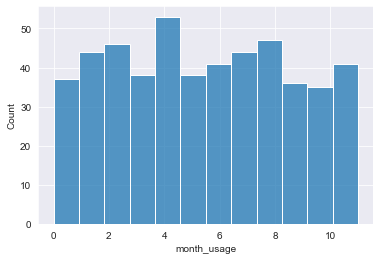

In [537]:
sns.histplot(
    data=user_profit['month_usage'],
    bins=(1+user_profit['month_usage'].max())
)

In [546]:
display(
    pd.Timestamp(np.datetime64('2018-01-29')) + pd.DateOffset(months=2)
)

Timestamp('2018-03-29 00:00:00')

#### количество сделанных звонков и израсходованных минут разговора по месяцам;

In [ ]:
def calls_mins(u_id, u_mnth):
    print(u_id, u_mnth)

In [494]:
display(
    user_profit.loc[
        user_profit['month_usage'] > 0
        , 'user_id'
    ].count()
)

482

#### количество отправленных сообщений по месяцам;

#### объем израсходованного интернет-трафика по месяцам;

#### помесячную выручку с каждого пользователя

(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

<hr>

## Шаг 3. Анализ данных

### Описание поведения клиентов оператора, исходя из выборки.

#### Сколько минут разговора требуется пользователям каждого тарифа в месяц?

 ##### Среднее количество минут, дисперсия и стандартное отклонение.

##### Гистограммы минут разговора.

##### Описание распределений минут разговора.

<hr>

#### Сколько сообщений требуется пользователям каждого тарифа в месяц?

 ##### Среднее количество сообщений, дисперсия и стандартное отклонение.

##### Гистограммы сообщений.

##### Описание распределений сообщений.

<hr>

#### Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

 Посчитайте среднее количество интернет-трафика, дисперсию и стандартное отклонение.

##### Гистограммы интернет-трафика.

##### Описание распределений интернет-трафика.

<hr>

## Шаг 4. Проверьте гипотезы

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

<hr>

## Шаг 5. Общий вывод

Описание данных
Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана
Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок
Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение
Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя
Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)